<a href="https://colab.research.google.com/github/SimplyDifficult/ML-for-Wireless/blob/main/2.%2020_dim_user_case_BOGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
P_max = 10 #in dBm

In [ ]:
var = 20
number_of_cells = 4

In [ ]:
!sudo add-apt-repository ppa:octave/stable
!sudo apt update
!sudo apt install octave

In [ ]:
!wget https://www.dropbox.com/s/llve9s3hfamwyni/function_uncorrelated_rayleigh_fading_channel_model.m
!wget https://www.dropbox.com/s/d1ytzzfpxsrpbcv/main_bitchanged.m -O /content/main.m
!wget https://www.dropbox.com/s/v3y2xe56qodthnm/function_SE.m
!wget https://www.dropbox.com/s/5p0j4qdqist7ibm/main_individual_transmit_case_for_Test_phase_bitchanged.m -O /content/main_individual_transmit_case_for_Test_phase.m

In [ ]:
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
from scipy.optimize import minimize
import numpy as np
from scipy.io import loadmat, savemat
import numpy as np
from google.colab import files
import cv2
from scipy.optimize import dual_annealing

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#### Objective function
import random
def objective(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W main.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [ ]:
#surrogate or approximation for the objective function
def surrogate(model, X):
	#catch any warning generated when making a prediction
	with catch_warnings():
		#ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

In [ ]:
def UCBobjective(Xsamples, X, model, beta):
  Xsamples = Xsamples[np.newaxis,:]
  mu, std = surrogate(model, Xsamples)
  mu = mu[:, 0]
  sigma = beta
  probs = mu + sigma * std
  return -probs[0]

In [ ]:
#optimize the acquisition function
def opt_acquisition(X, y, model, iteration):
  #Do it 5 times
  r_min, r_max = -31.0, P_max  
  bounds = []
  for ti in range(var):
    bounds = bounds + [[r_min, r_max]]
  min_result = 9999999999999.0
  min_answer = 0
  beta = np.sqrt(1.5*(2*np.log((iteration**((20/2.) + 2))*(np.pi**2)/(3. * 0.1))))
  
  for i in range(5):
    result = dual_annealing(UCBobjective, bounds, args=(X,model,beta))
    if(result.fun<min_result):
      min_result = result.fun
      min_answer = result['x']    
  return min_answer

In [ ]:
import random
def objective_FPA(tr_array):
  tr_in_mW = np.power(10,tr_array/10.0)
  savemat("transmit.mat", {"transmit":(tr_in_mW)})
  !octave -W /content/main_individual_transmit_case_for_Test_phase.m
  SE = loadmat('SE.mat')
  return np.sum(SE["SE"])

In [ ]:
X = P_max * np.ones([1,var], dtype = "float")
y = np.array([[objective(X[0].reshape((int)(var/number_of_cells), number_of_cells))]])

In [ ]:
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

x_axis = [-31]
y_axis = [0]
x_axis_FPA = [-31]
y_axis_FPA = [0]

for p in range(9):
  X = 0 * np.ones([1,var], dtype = "float")
  y = np.array([[objective_FPA(X[0].reshape((int)(var/number_of_cells), number_of_cells))]])

  tr_FPA = objective_FPA(P_max * np.ones([1,var], dtype = "float").reshape((int)(var/number_of_cells), number_of_cells))
  y_FPA = np.array([[tr_FPA]])

  kernels =  ConstantKernel(constant_value=200, constant_value_bounds = (1e-20, 1e20)) * Matern(length_scale=1, length_scale_bounds=(1e-20,1e20), nu=1.5) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-20, 1e20)) 
  model = GaussianProcessRegressor(kernel = kernels, n_restarts_optimizer=30)

  model.fit(X, y)

  for i in range(200):
    x_next = opt_acquisition(X, y, model, X.shape[0])
  
    tr = 0
    for l in range(1):
      tr = tr + objective_FPA(x_next.reshape((int)(var/number_of_cells), number_of_cells))
    tr = tr/1.0  
    actual = tr

    tr_FPA = objective_FPA(P_max * np.ones([1,var], dtype = "float").reshape((int)(var/number_of_cells), number_of_cells))
  
    est, _ = surrogate(model, [x_next])
#    print("x_next is", x_next)
#    print('f()=%3f, actual=%.3f' % (est, actual))
  
    X = vstack((X, [x_next]))
    y = vstack((y, [[actual]]))
    y_FPA = vstack((y_FPA, [[tr_FPA]]))
  
    model.fit(X, y)

    pyplot.xlabel("Iterations")
    pyplot.ylabel("Performance")
    pyplot.plot(np.arange(1,X.shape[0]+1),y[:])
    pyplot.plot(np.arange(1,X.shape[0]+1), y_FPA[:])
    pyplot.legend(["BOGP Perfromance","FPA Performance"])
    pyplot.show()
   
  ix = 0
  ix = argmax(y)
  print('P_max = %.3f, Optimal_SE = %.3f' % (P_max, y[ix]))
  x_axis.append(P_max)
  y_axis.append(y[ix])
  ix_FPA=0
  ix_FPA=argmax(y_FPA)
  print('P_max = %.3f, Optimal_SE_FPA = %.3f' % (P_max, y_FPA[ix_FPA]))
  x_axis_FPA.append(P_max)
  y_axis_FPA.append(y_FPA[ix_FPA])
  P_max = P_max+10



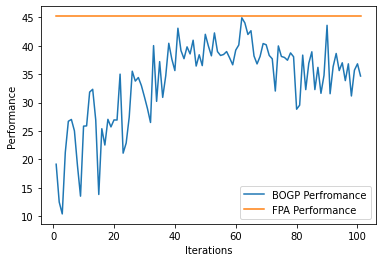

P_max=10.0, Optimal_SE=44.904, Optimal_SE_FPA=45.177


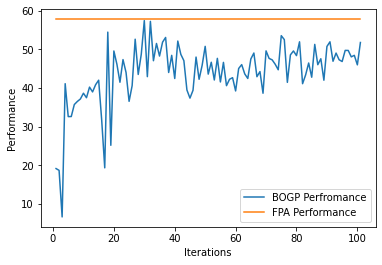

P_max=20.0, Optimal_SE=57.460, Optimal_SE_FPA=57.809


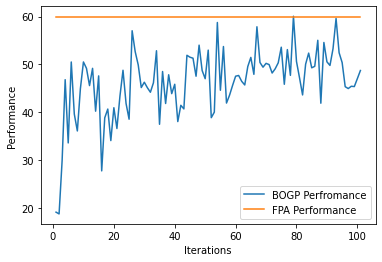

P_max=30.0, Optimal_SE=60.070, Optimal_SE_FPA=59.935


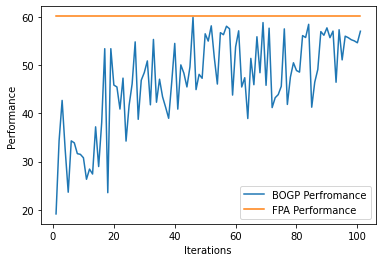

P_max=40.0, Optimal_SE=59.934, Optimal_SE_FPA=60.165


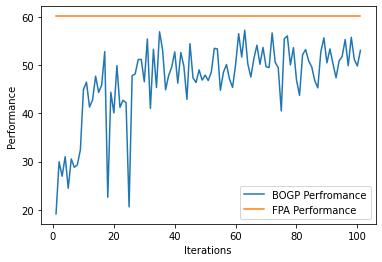

P_max=50.0, Optimal_SE=57.289, Optimal_SE_FPA=60.189


In [49]:
from IPython.display import Image, display
display(Image('P=10.0.png'))
print('P_max=10.0, Optimal_SE=44.904, Optimal_SE_FPA=45.177')

display(Image('P=20.0.png'))
print('P_max=20.0, Optimal_SE=57.460, Optimal_SE_FPA=57.809')

display(Image('P=30.0.png'))
print('P_max=30.0, Optimal_SE=60.070, Optimal_SE_FPA=59.935')

display(Image('P=40.0.png'))
print('P_max=40.0, Optimal_SE=59.934, Optimal_SE_FPA=60.165')

display(Image('P=50.0.png'))
print('P_max=50.0, Optimal_SE=57.289, Optimal_SE_FPA=60.189')